### Transformer深入浅出

学习transformer模型入门教程。

我们从零开始用pytorch搭建Transformer模型。

训练它来实现一个有趣的实例：两数之和。

输入输出类似如下：

输入："<SOS>12345+54321<EOS>"
输出："<SOS>66666<EOS>"
    
我们把这个任务当做一个机器翻译任务来进行。输入是一个字符序列，输出也是一个字符序列(seq-to-seq).
    
这和机器翻译的输入输出结构是类似的，所以可以用Transformer来做。
    

## 环境准备

In [2]:
pip install torch torchvision torchaudio plotly seaborn torchkeras torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
import plotly.express as px 

In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set(rc = {'figure.figsize':(15,15)})


## 一. 准备数据

In [6]:
import random

import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader

# 定义字典
words_x = '<PAD>,1,2,3,4,5,6,7,8,9,0,<SOS>,<EOS>,+'
vocab_x = {word: i for i, word in enumerate(words_x.split(','))}
vocab_xr = [k for k, v in vocab_x.items()] #反查词典

words_y = '<PAD>,1,2,3,4,5,6,7,8,9,0,<SOS>,<EOS>'
vocab_y = {word: i for i, word in enumerate(words_y.split(','))}
vocab_yr = [k for k, v in vocab_y.items()] #反查词典


In [7]:
#两数相加数据集
def get_data():
    # 定义词集合
    words = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    # 每个词被选中的概率
    p = np.array([7, 5, 5, 7, 6, 5, 7, 6, 5, 7])
    p = p / p.sum()

    # 随机采样n1个词作为s1
    n1 = random.randint(10, 20)
    s1 = np.random.choice(words, size=n1, replace=True, p=p)
    s1 = s1.tolist()

    # 随机采样n2个词作为s2
    n2 = random.randint(10, 20)
    s2 = np.random.choice(words, size=n2, replace=True, p=p)
    s2 = s2.tolist()

    # x等于s1和s2字符上的相加
    x = s1 + ['+'] + s2
    
    # y等于s1和s2数值上的相加
    y = int(''.join(s1)) + int(''.join(s2))
    y = list(str(y))
    
    # 加上首尾符号
    x = ['<SOS>'] + x + ['<EOS>']
    y = ['<SOS>'] + y + ['<EOS>']

    # 补pad到固定长度
    x = x + ['<PAD>'] * 50
    y = y + ['<PAD>'] * 51
    x = x[:50]
    y = y[:51]

    # 编码成token
    token_x = [vocab_x[i] for i in x]
    token_y = [vocab_y[i] for i in y]

    # 转tensor
    tensor_x = torch.LongTensor(token_x)
    tensor_y = torch.LongTensor(token_y)
    return tensor_x, tensor_y


def show_data(tensor_x,tensor_y) ->"str":
    words_x = "".join([vocab_xr[i] for i in tensor_x.tolist()])
    words_y = "".join([vocab_yr[i] for i in tensor_y.tolist()])
    return words_x,words_y


x,y = get_data() 
print(x,y,"\n")
print(show_data(x,y)) 


tensor([11, 10,  7,  5, 10,  9,  8,  9,  6,  7,  9,  4,  3, 13,  3,  5,  3,  5,
         6,  4,  4,  7,  9, 10, 10,  8,  6,  8,  2, 12,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]) tensor([11,  3,  5,  3,  6,  3,  9,  5,  7,  7,  9,  7,  6,  6,  2,  5, 12,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]) 

('<SOS>075098967943+353564479008682<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>', '<SOS>353639577976625<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>')


In [8]:
# 定义数据集
class TwoSumDataset(torch.utils.data.Dataset):
    def __init__(self,size = 100000):
        super(Dataset, self).__init__()
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, i):
        return get_data()
    
ds_train = TwoSumDataset(size = 100000)
ds_val = TwoSumDataset(size = 10000)


# 数据加载器
dl_train = DataLoader(dataset=ds_train,
         batch_size=200,
         drop_last=True,
         shuffle=True)

dl_val = DataLoader(dataset=ds_val,
         batch_size=200,
         drop_last=True,
         shuffle=False)


In [9]:
for src,tgt in dl_train:
    print(src.shape)
    print(tgt.shape)
    break 

torch.Size([200, 50])
torch.Size([200, 51])


## 二. 定义模型

下面，我们会像搭积木建城堡那样从低往高地构建Transformer模型。

先构建6个基础组件：多头注意力、前馈网络、层归一化、残差连接、单词嵌入、位置编码。类似用最基础的积木块搭建了 墙壁，屋顶，篱笆，厅柱，大门，窗户 这样的模块。

然后用这6个基础组件构建了3个中间成品: 编码器，解码器，产生器。类似用基础组件构建了城堡的主楼，塔楼，花园。 

最后用这3个中间成品组装成Tranformer完整模型。类似用主楼，塔楼，花园这样的中间成品拼凑出一座完整美丽的城堡。

1. 多头注意力: MultiHeadAttention (用于融合不同单词之间的信息, 三处使用场景，①Encoder self-attention, ② Decoder masked-self-attention, ③ Encoder-Decoder cross-attention)

2. 前馈网络: PositionwiseFeedForward (用于逐位置将多头注意力融合后的信息进行高维映射变换，简称FFN)

3. 层归一化: LayerNorm (用于稳定输入，每个样本在Sequece和Feature维度归一化,相比BatchNorm更能适应NLP领域变长序列)

4. 残差连接: ResConnection (用于增强梯度流动以降低网络学习难度, 可以先LayerNorm再Add，LayerNorm也可以放在残差Add之后)

5. 单词嵌入: WordEmbedding (用于编码单词信息，权重要学习，输出乘了sqrt(d_model)来和位置编码保持相当量级)

6. 位置编码: PositionEncoding (用于编码位置信息，使用sin和cos函数直接编码绝对位置)

**************************************************************************************************************

7. 编码器: TransformerEncoder (用于将输入Sequence编码成与Sequence等长的memory向量序列, 由N个TransformerEncoderLayer堆叠而成)

8. 解码器: TransformerDecoder (用于将编码器编码的memory向量解码成另一个不定长的向量序列, 由N个TransformerDecoderLayer堆叠而成)

9. 生成器: Generator (用于将解码器解码的向量序列中的每个向量映射成为输出词典中的词，一般由一个Linear层构成)

*************************************************************************************************************

10.  Transformer (用于Seq2Seq转码，例如用于机器翻译，采用EncoderDecoder架构，由Encoder, Decoder 和 Generator组成)



In [10]:
import torch 
from torch import nn 
import torch.nn.functional as F
import copy 
import math 
import numpy as np
import pandas as pd 

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


### 2.1 多头注意力 MultiHeadAttention 

需要逐步理解 ScaledDotProductAttention->MultiHeadAttention->MaskedMultiHeadAttention

先理解什么是 ScaledDotProductAttention，再理解MultiHeadAttention， 然后理解MaskedMultiHeadAttention



In [11]:
class ScaledDotProductAttention(nn.Module):
    "Compute 'Scaled Dot Product Attention'"
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self,query, key, value, mask=None, dropout=None):
        d_k = query.size(-1)
        scores = query@key.transpose(-2,-1) / math.sqrt(d_k)     
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e20)
        p_attn = F.softmax(scores, dim = -1)
        if dropout is not None:
            p_attn = dropout(p_attn)
        return p_attn@value, p_attn
    
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None #记录 attention矩阵结果
        self.dropout = nn.Dropout(p=dropout)
        self.attention = ScaledDotProductAttention()
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))
        ]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = self.attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


#为了让训练过程与解码过程信息流一致，遮挡tgt序列后面元素，设置其注意力为0
def tril_mask(data):
    "Mask out future positions."
    size = data.size(-1) #size为序列长度
    full = torch.full((1,size,size),1,dtype=torch.int,device=data.device)
    mask = torch.tril(full).bool() 
    return mask


#设置对<PAD>的注意力为0
def pad_mask(data, pad=0):
    "Mask out pad positions."
    mask = (data!=pad).unsqueeze(-2)
    return mask 


#计算一个batch数据的src_mask和tgt_mask
class MaskedBatch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, tgt=None, pad=0):
        self.src = src
        self.src_mask = pad_mask(src,pad)
        if tgt is not None:
            self.tgt = tgt[:,:-1] #训练时,拿tgt的每一个词输入,去预测下一个词,所以最后一个词无需输入
            self.tgt_y = tgt[:, 1:] #第一个总是<SOS>无需预测，预测从第二个词开始
            self.tgt_mask = \
                self.make_tgt_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y!= pad).sum() 
    
    @staticmethod
    def make_tgt_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_pad_mask = pad_mask(tgt,pad)
        tgt_tril_mask = tril_mask(tgt)
        tgt_mask = tgt_pad_mask & (tgt_tril_mask)
        return tgt_mask
    

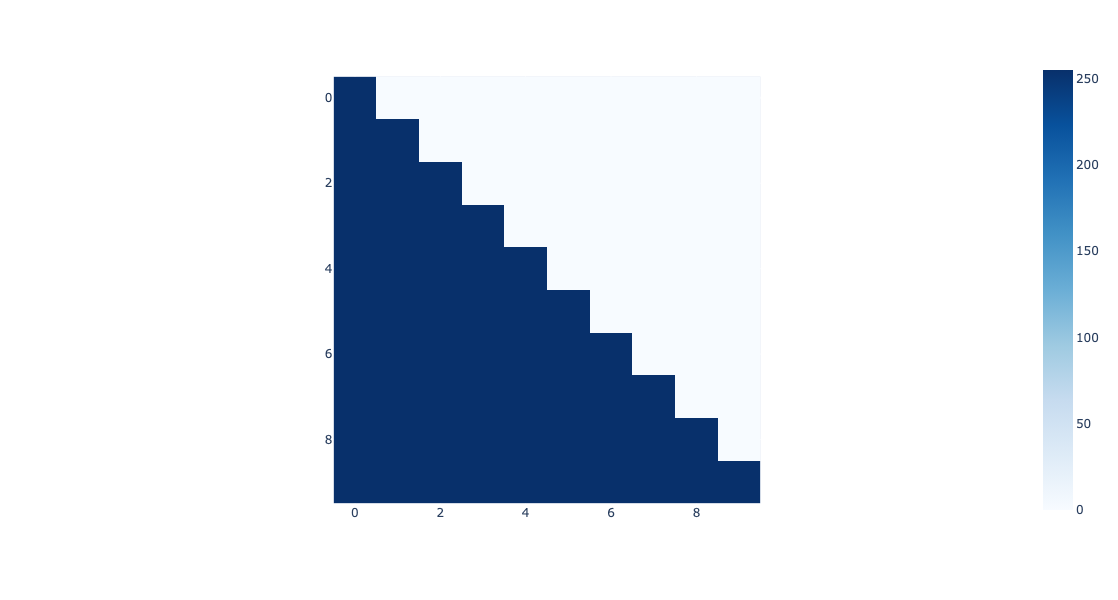

In [12]:
# 测试tril_mask 
mask = tril_mask(torch.zeros(1,10)) #序列长度为10
#sns.heatmap(mask[0],cmap=sns.cm.rocket);
px.imshow(mask[0],color_continuous_scale="blues",height=600,width=600)


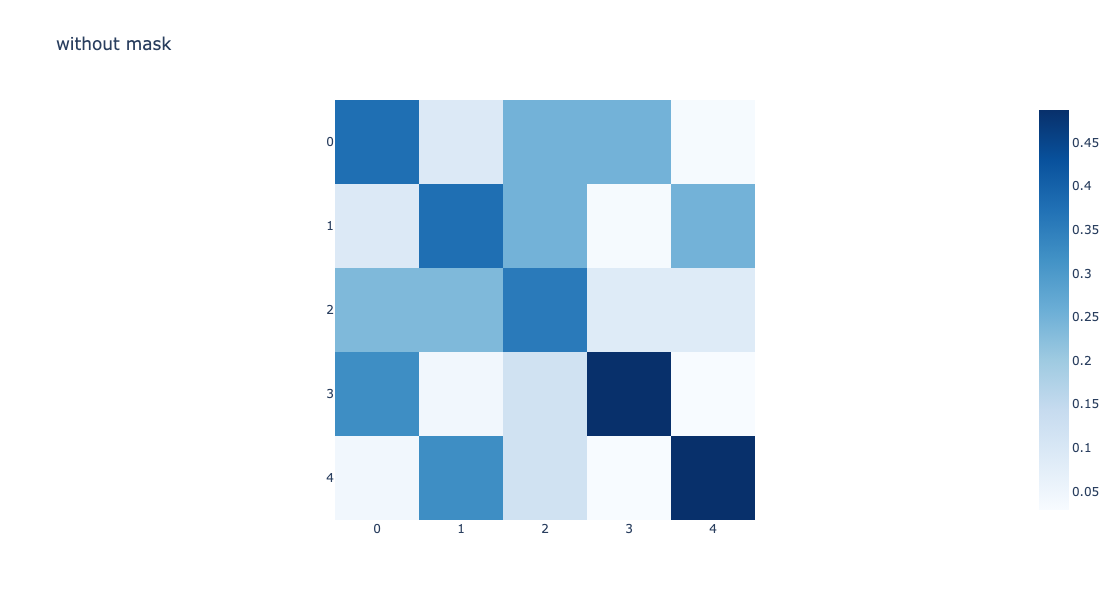

In [13]:
#测试 ScaledDotProductAttention

query = torch.tensor([[[0.0,1.414],[1.414,0.0],[1.0,1.0],[-1.0,1.0],[1.0,-1.0]]])
key = query.clone() 
value = query.clone()

attention = ScaledDotProductAttention()

#没有mask 
out,p_att = attention(query, key, value)
fig = px.imshow(p_att[0],color_continuous_scale="blues",
                title="without mask",height=600,width=600)
fig.show() 

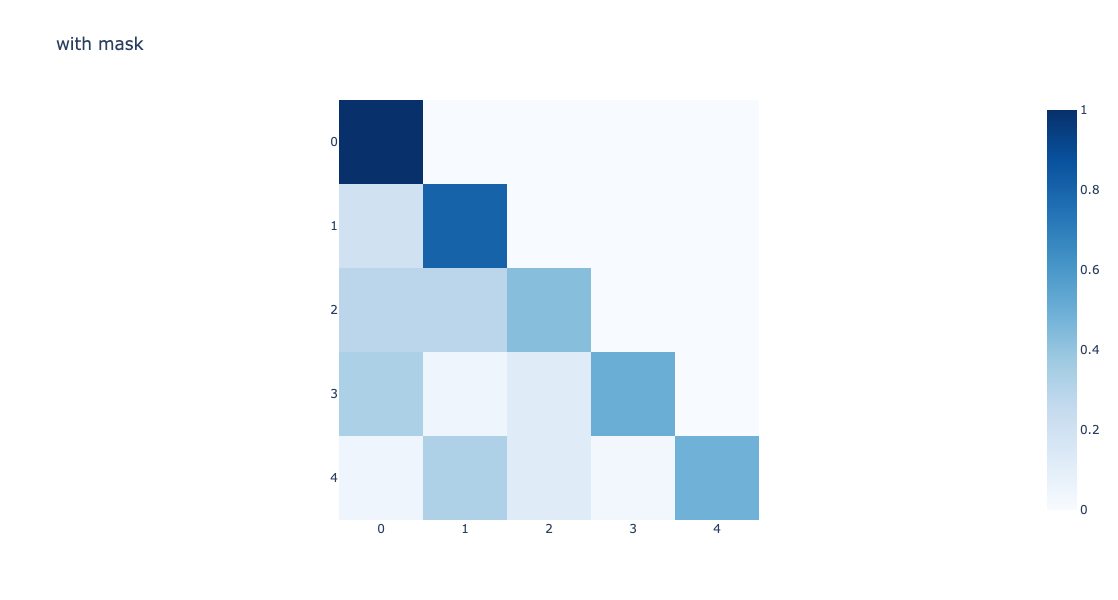

In [14]:
#考虑mask
out,p_att = attention(query, key, value, mask = tril_mask(torch.zeros(3,5)))
fig = px.imshow(p_att[0],color_continuous_scale="blues",
                height=600,width=600,
                title="with mask")
fig.show() 

In [15]:
# 测试MultiHeadAttention
cross_attn = MultiHeadAttention(h=2, d_model=4)
cross_attn.eval()
q1 = torch.tensor([[[0.1,0.1,0.1,0.1],[0.1,0.3,0.1,0.3]]])
k1 = q1.clone()
v1 = q1.clone()
tgt_mask = tril_mask(torch.zeros(2,2))

out1 = cross_attn.forward(q1,k1,v1,mask = tgt_mask)
print("out1:\n",out1)

#改变序列的第2个元素取值，由于有mask的遮挡，不会影响第1个输出
q2 = torch.tensor([[[0.1,0.1,0.1,0.1],[0.4,0.5,0.5,0.8]]])
k2 = q2.clone()
v2 = q2.clone()
tgt_mask = tril_mask(torch.zeros(2,2))
out2 = cross_attn.forward(q2,k2,v2,mask = tgt_mask)
print("out2:\n",out2)


out1:
 tensor([[[-0.0373,  0.4337,  0.0384, -0.3304],
         [-0.0582,  0.3908,  0.0481, -0.3373]]], grad_fn=<ViewBackward0>)
out2:
 tensor([[[-0.0373,  0.4337,  0.0384, -0.3304],
         [-0.1312,  0.2912,  0.1359, -0.3415]]], grad_fn=<ViewBackward0>)


torch.Size([200, 50])
torch.Size([200, 50])
torch.Size([200, 50])
torch.Size([200, 1, 50])
torch.Size([200, 50, 50])


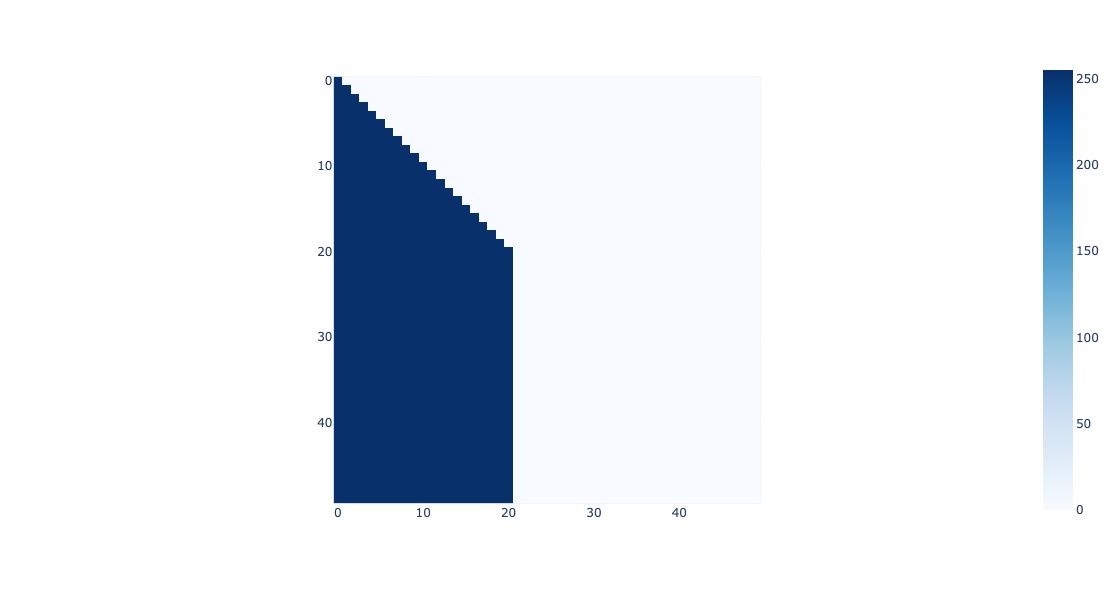

In [16]:
# 测试MaskedBatch
mbatch = MaskedBatch(src = src,tgt = tgt, pad = 0)
print(mbatch.src.shape)
print(mbatch.tgt.shape)
print(mbatch.tgt_y.shape)

print(mbatch.src_mask.shape)
print(mbatch.tgt_mask.shape)
px.imshow(mbatch.tgt_mask[0],color_continuous_scale="blues",width=600,height=600)

关于Transformer的多头注意力机制，有几个要点问题，此处做一些梳理：


(1)，Transformer是如何解决长距离依赖的问题的？

Transformer是通过引入Scale-Dot-Product注意力机制来融合序列上不同位置的信息，从而解决长距离依赖问题。以文本数据为例，在循环神经网络LSTM结构中，输入序列上相距很远的两个单词无法直接发生交互，只能通过隐藏层输出或者细胞状态按照时间步骤一个一个向后进行传递。对于两个在序列上相距非常远的单词，中间经过的其它单词让隐藏层输出和细胞状态混入了太多的信息，很难有效地捕捉这种长距离依赖特征。但是在Scale-Dot-Product注意力机制中，序列上的每个单词都会和其它所有单词做一次点积计算注意力得分，这种注意力机制中单词之间的交互是强制的不受距离影响的，所以可以解决长距离依赖问题。


(2)，Transformer在训练和测试阶段可以在时间(序列)维度上进行并行吗？

在训练阶段，Encoder和Decoder在时间(序列)维度都是并行的，在测试阶段，Encoder在序列维度是并行的，Decoder是串行的。

首先，Encoder部分在训练阶段和预测阶段都可以并行比较好理解，无论在训练还是预测阶段，它干的事情都是把已知的完整输入编码成memory，在序列维度可以并行。

对于Decoder部分有些微妙。在预测阶段Decoder肯定是不能并行的，因为Decoder实际上是一个自回归，它前面k-1位置的输出会变成第k位的输入的。前面没有计算完，后面是拿不到输入的，肯定不可以并行。那么训练阶段能否并行呢？虽然训练阶段知道了全部的解码结果，但是训练阶段要和预测阶段一致啊，前面的解码输出不能受到后面解码结果的影响啊。但Transformer通过在Decoder中巧妙地引入Mask技巧，使得在用Attention机制做序列特征融合的时候，每个单词对位于它之后的单词的注意力得分都为0，这样就保证了前面的解码输出不会受到后面解码结果的影响，因此Decoder在训练阶段可以在序列维度做并行。


(3)，Scaled-Dot Product Attention为什么要除以$\sqrt{d_k}$?

为了避免$d_k$变得很大时softmax函数的梯度趋于0。假设Q和K中的取出的两个向量$q$和$k$的每个元素值都是正态随机分布，数学上可以证明两个独立的正态随机变量的积依然是一个正态随机变量，那么两个向量做点积，会得到$d_k$个正态随机变量的和，数学上$d_k$个正态随机变量的和依然是一个正态随机变量，其方差是原来的$d_k$倍，标准差是原来的$\sqrt{d_k}$倍。如果不做scale, 当$d_k$很大时，求得的$QK^T$元素的绝对值容易很大，导致落在softmax的极端区域(趋于0或者1)，极端区域softmax函数的梯度值趋于0，不利于模型学习。除以$\sqrt{d_k}$，恰好做了归一，不受$d_k$变化影响。


(4)，MultiHeadAttention的参数数量和head数量有何关系?

MultiHeadAttention的参数数量和head数量无关。多头注意力的参数来自对QKV的三个变换矩阵以及多头结果concat后的输出变换矩阵。假设嵌入向量的长度是d_model, 一共有h个head. 对每个head，$W_{i}^{Q},W_{i}^{K},W_{i}^{V}$ 这三个变换矩阵的尺寸都是 d_model×(d_model/h)，所以h个head总的参数数量就是3×d_model×(d_model/h)×h = 3×d_model×d_model。它们的输出向量长度都变成 d_model/h，经过attention作用后向量长度保持，h个head的输出拼接到一起后向量长度还是d_model，所以最后输出变换矩阵的尺寸是d_model×d_model。因此，MultiHeadAttention的参数数量为 4×d_model×d_model，和head数量无关。



### 2.2 前馈网络: PositionwiseFeedForward

用于逐位置将多头注意力融合后的信息进行高维映射变换，简称FFN。

FFN仅有两个线性层，第一层将模型向量维度 从 d_model(512) 升到 d_ff(2048), 第二层再降回 d_model(512)

两个线性层之间加了一个0.1的Dropout



In [17]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)  #线性层默认作用在最后一维度
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))
    


### 2.3 层归一化：LayerNorm

在视觉领域，归一化一般用BatchNorm，但是在NLP领域，归一化一般用LayerNorm。

这是由于NLP领域的输入常常是不等长的Sequence，使用BatchNorm会让较长的Sequence输入的后面特征能够使用的参与归一化的样本数太少，让输入变得不稳定。

同时同一个Sequence的被PADDING填充的特征也会因BatchNorm获得不同的非零值，这对模型非常不友好。
    
相比之下，LayerNorm总是对一个样本自己的特征进行归一化，没有上述问题。


In [18]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (similar to torch.nn.LayerNorm)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.weight * (x - mean) / (std + self.eps) + self.bias
    


### 2.4 残差连接：ResConnection

用于增强梯度流动以降低网络学习难度。

ResConnection 包括LayerNorm和Add残差连接操作, LayerNorm可以放在最开始(norm_first=True)，也可以放在最后(norm_first=False)。

《Attention is All you needed》论文原文是残差连接之后再 LayerNorm，但后面的一些研究发现最开始的时候就LayerNorm更好一些。

残差连接对于训练深度网络至关重要。有许多研究残差连接(ResNet)作用机制，解释它为什么有效的文章，主要的一些观点如下。

1，残差连接增强了梯度流动。直观上看，loss端的梯度能够通过跳跃连接快速传递到不同深度的各个层，增强了梯度流动，降低了网络的学习难度。数学上看，残差块的导数 f(x)=x+h(x) 为 f'(x)=1+h'(x) 在1.0附近，避免了梯度消失问题。

2，残差连接减轻了网络退化。一个网络层h(x)可以用一个变换矩阵H来表示，由于许多神经元有相同的反应模式，h(x)等价的变换矩阵H可能有许多行是线性相关的，这使得H的行列式为0，H为非可逆矩阵，h(x)会导致网络的退化和信息丢失。但增加了残差连接之后，f(x)=x+h(x)对应的变换矩阵F=H+I，单位阵I消除了H中相关行的线性相关性，减轻了退化的可能。

3，残差连接实现了模型集成。如果将训练好的ResNet的一些block移除，模型的预测精度并不会崩溃式下降，但是如果将训练好的VGG的一些block移除，模型的预测精度会雪崩。这说明ResNet中的各个Block类似基模型，ResNet通过残差连接将它们整合成了一个ensemble集成模型，增强了泛化能力。

4，残差连接增强了表达能力。使用残差块构建的深层网络所代表的函数簇集合是浅层网络所代表的的函数簇集合的超集，表达能力更强，所以可以通过添加残差块不断扩充模型表达能力。 如果不使用残差连接，一个一层的网络f(x) = h1(x)  所能表示的函数簇 不一定能被一个二层的网络 f(x) = h2(h1(x))所覆盖，但是使用残差连接后，f(x) = h1(x)+h2(h1(x))一定可以覆盖一层的网络所表示的函数簇，只要h2的全部权重取0即可。

参考：https://zhuanlan.zhihu.com/p/165350103



In [19]:
class ResConnection(nn.Module):
    """
    A residual connection with a layer norm.
    Note the norm is at last according to the paper, but it may be better at first.
    """
    def __init__(self, size, dropout, norm_first=True):
        super(ResConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        self.norm_first = norm_first

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        if self.norm_first:
            return x + self.dropout(sublayer(self.norm(x)))
        else:
            return self.norm(x + self.dropout(sublayer(x)))
        

### 2.5 单词嵌入: WordEmbedding(权重要学习)


用于编码单词信息，权重要学习，输出乘了sqrt(d_model)来和位置编码保持相当量级。

当d_model越大的时候，根据 nn.init.xavier_uniform 初始化策略初始化的权重取值会越小。


In [20]:
# 单词嵌入
class WordEmbedding(nn.Module):
    def __init__(self, d_model, vocab):
        super(WordEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model) #note here, multiply sqrt(d_model)
    

### 2.6 位置编码：PositionEncoding(直接编码)

PositionEncoding用于编码位置信息，使用sin和cos函数直接编码绝对位置。

单词和单词顺序对语言意义都非常重要。

"你欠我1000块钱"和"我欠你1000块钱"是由完全相同的单词组成，但由于词的顺序不同，含义截然相反。

在Transformer之前，一般用RNN模型来处理句子序列。

RNN模型本身蕴含了对顺序的建模，单词是按照它们在句子中的自然顺序一个个地被RNN单元处理，逐个地被编码。

但Transformer是并行地处理句子中的单词的，缺少单词的位置信息表征。

为了有效地表征单词的位置信息，Transformer设计了位置编码 PositionalEncoding，并添加到模型的输入中。

于是，Transformer 用单词嵌入(权重要学习)向量 和位置编码(直接编码)向量 之和 来表示输入。

如何构造位置编码呢？即如何 把 pos = 0,1,2,3,4,5,... 这样的位置序列映射成为 一个一个的向量呢?

Transformer设计了基于正弦函数和余弦函数的位置编码方法。

![](img/fomula.1.jpeg)

这种编码方法有以下几个优点：

1，编码值分布在[-1,1]之间，这样的分布对神经网络是比较友好的。

2，编码了绝对位置信息，对于0<=pos<=2*pi*10000，每个pos的位置编码向量都是不一样的。


更多位置编码的讨论参考如下博客：

《让研究人员绞尽脑汁的Transformer位置编码》

https://kexue.fm/archives/8130 


In [21]:
# 位置编码
class PositionEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
    

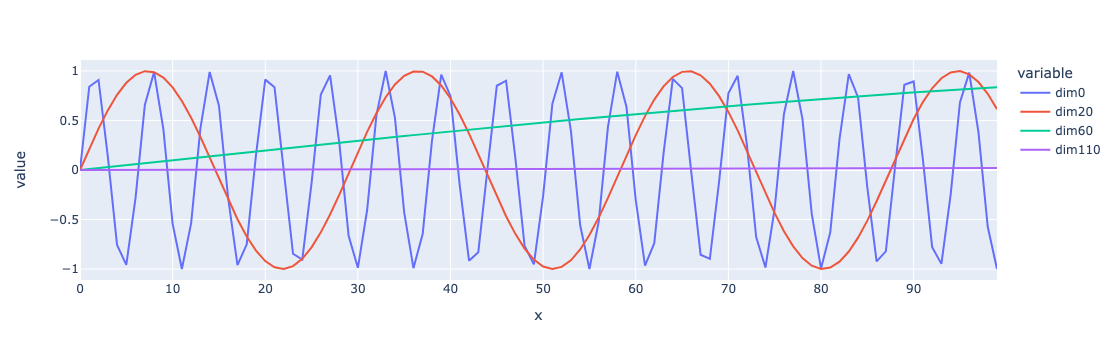

In [22]:
pe = PositionEncoding(120, 0)
z = pe.forward(torch.zeros(1, 100, 120))
df = pd.DataFrame(z[0, :, [0,20,60,110]].data.numpy(),columns = ["dim"+c for c in ['0','20','60','110']])
df.insert(0,"x",np.arange(100))
px.line(df, x = "x",y = ["dim"+c for c in ['0','20','60','110']]).show() 


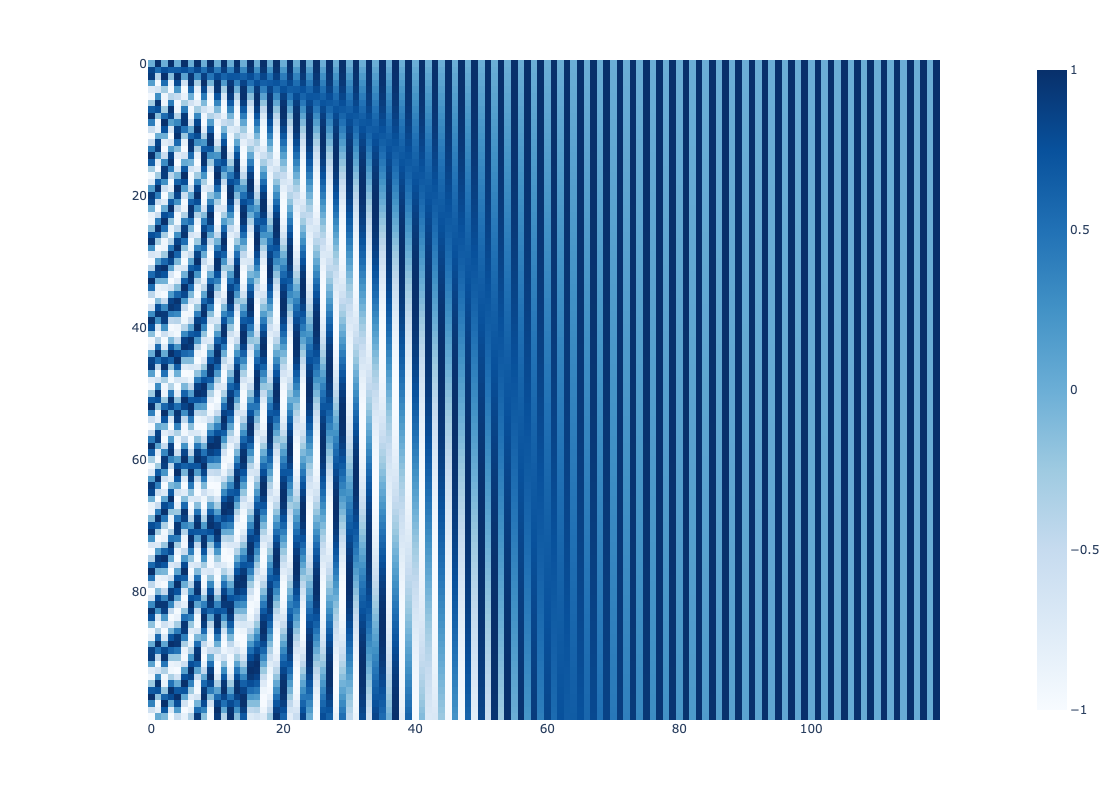

In [23]:
px.imshow(np.squeeze(z.data.numpy()) ,color_continuous_scale="blues",width=1000,height=800) 


### 2.7  编码器: TransformerEncoder 

用于将输入Sequence编码成与Sequence等长的memory向量序列, 由N个TransformerEncoderLayer堆叠而成




In [24]:
class TransformerEncoderLayer(nn.Module):
    "TransformerEncoderLayer is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.res_layers = clones(ResConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.res_layers[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.res_layers[1](x, self.feed_forward)
    
    
class TransformerEncoder(nn.Module):
    "TransformerEncoder is a stack of N TransformerEncoderLayer"
    def __init__(self, layer, N):
        super(TransformerEncoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
    @classmethod
    def from_config(cls,N=6,d_model=512, d_ff=2048, h=8, dropout=0.1):
        attn = MultiHeadAttention(h, d_model)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        layer = TransformerEncoderLayer(d_model, attn, ff, dropout)
        return cls(layer,N)
    

In [25]:
from torchkeras import summary 

src_embed = nn.Sequential(WordEmbedding(d_model=32, vocab = len(vocab_x)), 
                          PositionEncoding(d_model=32, dropout=0.1))
encoder = TransformerEncoder.from_config(N=3,d_model=32, d_ff=128, h=8, dropout=0.1)
src_mask = pad_mask(src)
memory = encoder(*[src_embed(src),src_mask]) 
summary(encoder,input_data_args = [src_embed(src),src_mask]);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
LayerNorm-1                             [-1, 50, 32]                   64
Linear-2                                [-1, 50, 32]                1,056
Linear-3                                [-1, 50, 32]                1,056
Linear-4                                [-1, 50, 32]                1,056
Dropout-5                            [-1, 8, 50, 50]                    0
ScaledDotProductAttention-6           [-1, 8, 50, 4]                    0
Linear-7                                [-1, 50, 32]                1,056
Dropout-8                               [-1, 50, 32]                    0
LayerNorm-9                             [-1, 50, 32]                   64
Linear-10                              [-1, 50, 128]                4,224
Dropout-11                             [-1, 50, 128]                    0
Linear-12                            

### 2.8 解码器：TransformerDecoder

用于将编码器编码的memory向量解码成另一个不定长的向量序列, 由N个TransformerDecoderLayer堆叠而成


In [26]:
class TransformerDecoderLayer(nn.Module):
    "TransformerDecoderLayer is made of self-attn, cross-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, cross_attn, feed_forward, dropout):
        super(TransformerDecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.cross_attn = cross_attn
        self.feed_forward = feed_forward
        self.res_layers = clones(ResConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.res_layers[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.res_layers[1](x, lambda x: self.cross_attn(x, m, m, src_mask))
        return self.res_layers[2](x, self.feed_forward)
    

In [27]:
class TransformerDecoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(TransformerDecoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
    
    @classmethod
    def from_config(cls,N=6,d_model=512, d_ff=2048, h=8, dropout=0.1):
        self_attn = MultiHeadAttention(h, d_model)
        cross_attn = MultiHeadAttention(h, d_model)
        ff = PositionwiseFeedForward(d_model, d_ff, dropout)
        layer = TransformerDecoderLayer(d_model, self_attn, cross_attn, ff, dropout)
        return cls(layer,N)


In [28]:
from torchkeras import summary 

mbatch = MaskedBatch(src=src,tgt=tgt,pad=0)

src_embed = nn.Sequential(WordEmbedding(d_model=32, vocab = len(vocab_x)), 
                          PositionEncoding(d_model=32, dropout=0.1))
encoder = TransformerEncoder.from_config(N=3,d_model=32, d_ff=128, h=8, dropout=0.1)
memory = encoder(src_embed(src),mbatch.src_mask) 

tgt_embed = nn.Sequential(WordEmbedding(d_model=32, vocab = len(vocab_y)), 
                          PositionEncoding(d_model=32, dropout=0.1))
decoder = TransformerDecoder.from_config(N=3,d_model=32, d_ff=128, h=8, dropout=0.1)

result = decoder.forward(tgt_embed(mbatch.tgt),memory,mbatch.src_mask,mbatch.tgt_mask) 
summary(decoder,input_data_args = [tgt_embed(mbatch.tgt),memory,
                              mbatch.src_mask,mbatch.tgt_mask]);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
LayerNorm-1                             [-1, 50, 32]                   64
Linear-2                                [-1, 50, 32]                1,056
Linear-3                                [-1, 50, 32]                1,056
Linear-4                                [-1, 50, 32]                1,056
Dropout-5                            [-1, 8, 50, 50]                    0
ScaledDotProductAttention-6           [-1, 8, 50, 4]                    0
Linear-7                                [-1, 50, 32]                1,056
Dropout-8                               [-1, 50, 32]                    0
LayerNorm-9                             [-1, 50, 32]                   64
Linear-10                               [-1, 50, 32]                1,056
Linear-11                               [-1, 50, 32]                1,056
Linear-12                            

In [29]:
decoder.eval() 
mbatch.tgt[0][1]=8
result = decoder.forward(tgt_embed(mbatch.tgt),memory,mbatch.src_mask,mbatch.tgt_mask)
print(torch.sum(result[0][0])) 

mbatch.tgt[0][1]=7
result = decoder.forward(tgt_embed(mbatch.tgt),memory,mbatch.src_mask,mbatch.tgt_mask)
print(torch.sum(result[0][0])) 


tensor(0., grad_fn=<SumBackward0>)
tensor(0., grad_fn=<SumBackward0>)


### 2.9 生成器: Generator 

用于将解码器解码输出的向量序列中的每个向量逐个映射成为输出词典中各个词的取词概率。

一般由一个Linear层接F.log_softmax构成，比较简单。

接F.log_softmax而不接F.softmax的原因是对于一些特别小的概率如1e-100，在精度约束条件下，F.log_softmax能够更加准确地表示其大小。


In [30]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


In [31]:
generator = Generator(d_model = 32, vocab = len(vocab_y)) 
log_probs  = generator(result)
probs = torch.exp(log_probs)
print("output_probs.shape:",probs.shape)
print("sum(probs)=1:") 
print(torch.sum(probs,dim = -1)[0]) 

summary(generator,input_data = result);


output_probs.shape: torch.Size([200, 50, 13])
sum(probs)=1:
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SelectBackward0>)
--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                [-1, 50, 13]                  429
Total params: 429
Trainable params: 429
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000076
Forward/backward pass size (MB): 0.004959
Params size (MB): 0.001637
Estimat

### 2.10 变形金刚：Transformer

用于Seq2Seq转码，例如用于机器翻译，采用EncoderDecoder架构，由Encoder, Decoder 和 Generator组成


In [32]:
from torch import nn 
class Transformer(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        self.reset_parameters()
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.generator(self.decode(self.encode(src, src_mask), 
                src_mask, tgt, tgt_mask))
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
    @classmethod
    def from_config(cls,src_vocab,tgt_vocab,N=6,d_model=512, d_ff=2048, h=8, dropout=0.1):
        encoder = TransformerEncoder.from_config(N=N,d_model=d_model,
                  d_ff=d_ff, h=h, dropout=dropout)
        decoder = TransformerDecoder.from_config(N=N,d_model=d_model,
                  d_ff=d_ff, h=h, dropout=dropout)
        src_embed = nn.Sequential(WordEmbedding(d_model, src_vocab), PositionEncoding(d_model, dropout))
        tgt_embed = nn.Sequential(WordEmbedding(d_model, tgt_vocab), PositionEncoding(d_model, dropout))
        
        generator = Generator(d_model, tgt_vocab)
        return cls(encoder, decoder, src_embed, tgt_embed, generator)
    
    def reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    


In [33]:
from torchkeras import summary 
net = Transformer.from_config(src_vocab = len(vocab_x),tgt_vocab = len(vocab_y),
                   N=2, d_model=32, d_ff=128, h=8, dropout=0.1)

mbatch = MaskedBatch(src=src,tgt=tgt,pad=0)

summary(net,input_data_args = [mbatch.src,mbatch.tgt,mbatch.src_mask,mbatch.tgt_mask]);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                             [-1, 50, 32]                  448
Dropout-2                               [-1, 50, 32]                    0
LayerNorm-3                             [-1, 50, 32]                   64
Linear-4                                [-1, 50, 32]                1,056
Linear-5                                [-1, 50, 32]                1,056
Linear-6                                [-1, 50, 32]                1,056
Dropout-7                            [-1, 8, 50, 50]                    0
ScaledDotProductAttention-8           [-1, 8, 50, 4]                    0
Linear-9                                [-1, 50, 32]                1,056
Dropout-10                              [-1, 50, 32]                    0
LayerNorm-11                            [-1, 50, 32]                   64
Linear-12                            

## 三. 训练模型

Transformer的训练主要用到了以下两个技巧：

1，学习率调度: Learning Rate Scheduler (用于提升模型学习稳定性。做法是学习率先warm up线性增长，再按照 1/sqrt(step) 规律缓慢下降)

2，标签平滑: Label Smoothing. (用于让模型更加集中在对分类错误的样本的学习，而不是扩大已经分类正确样本中正负样本预测差距。做法是将正例标签由1改成0.1，负例标签由0改成0.9/vocab_size)

介绍了用这两个方法封装的 Optimizer和 Loss 后，我们进一步实现完整训练代码。

3，完整训练代码。


### 3.1 学习率调度： Learning Rate Scheduler 

用于提升模型学习稳定性。

做法是学习率先warm up线性增长，再按照 1/sqrt(step) 规律缓慢下降。

学习率的warm up为何有效呢？

一种解释性观点是认为这能够让模型初始学习时参数平稳变化并避免对开始的几个batch数据过拟合陷入局部最优。

由于刚学习时，loss比较大，梯度会很大，如果学习率也很大，两者相乘会更大，那么模型参数会随着不同batch数据的差异剧烈抖动，无法有效地学习，也容易对开始的几个batch数据过拟合，后期很难拉回来。

等到模型学习了一些时候，loss变小了，梯度也会小，学习率调大，两者相乘也不会很大，模型依然可以平稳有效地学习。

后期为何又要让调低学习率呢？

这是因为后期模型loss已经很小了，在最优参数附近了，如果学习率过大，容易在最优参数附近震荡，无法逼近最优参数。

参考：https://www.zhihu.com/question/338066667


In [34]:
#注1：此处通过继承方法将学习率调度策略融入Optimizer
#注2：NoamOpt中的Noam是论文作者之一的名字
#注3：学习率是按照step而非epoch去改变的

class NoamOpt(torch.optim.AdamW):
    def __init__(self, params, model_size=512, factor=1.0, warmup=4000, 
                 lr=0, betas=(0.9, 0.98), eps=1e-9,
                 weight_decay=0, amsgrad=False):
        super(NoamOpt,self).__init__(params, lr=lr, betas=betas, eps=eps,
                 weight_decay=weight_decay, amsgrad=amsgrad)
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        
    def step(self,closure=None):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        super(NoamOpt,self).step(closure=closure)
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step * self.warmup ** (-1.5),step ** (-0.5)))
    
optimizer = NoamOpt(net.parameters(), 
        model_size=net.src_embed[0].d_model, factor=1.0, 
        warmup=400)


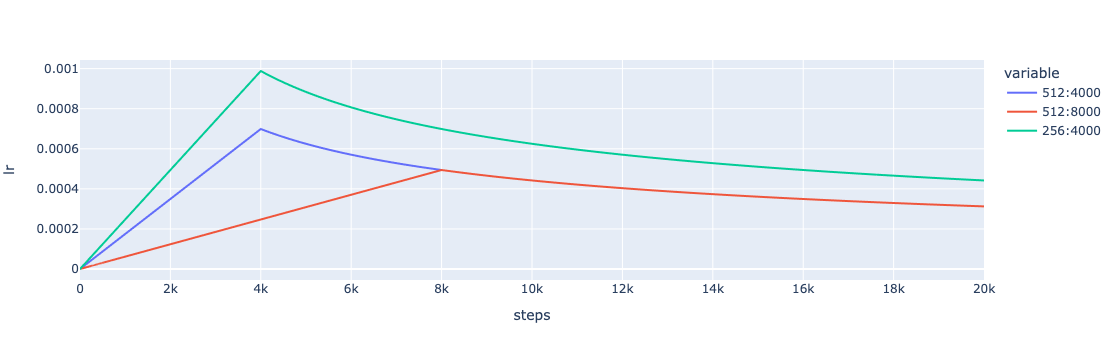

In [35]:
import plotly.express as px 

opts = [NoamOpt(net.parameters(),model_size=512, factor =1, warmup=4000), 
        NoamOpt(net.parameters(),model_size=512, factor=1,  warmup=8000),
        NoamOpt(net.parameters(),model_size=256, factor=1,  warmup=4000)]

steps = np.arange(1, 20000)
rates = [[opt.rate(i) for opt in opts] for i in steps]
dfrates = pd.DataFrame(rates,columns = ["512:4000", "512:8000", "256:4000"])
dfrates["steps"] = steps 

fig = px.line(dfrates,x="steps",y=["512:4000", "512:8000", "256:4000"])
fig.layout.yaxis.title = "lr"
fig 


### 3.2 标签平滑：Label Smoothing

用于让模型更加集中在对分类错误的样本的学习，而不是扩大已经分类正确样本中正负样本预测差距。

做法是将正例标签由1改成0.1，负例标签由0改成0.9/vocab_size

多分类一般用softmax激活函数，要让模型对正例标签预测值为1是非常困难的，那需要输出正无穷才可以.

对负例标签预测值为0也是非常困难的，那需要输出负无穷才可以。

但实际上我们不需要模型那么确信，只要正例标签的预测值比负例标签大就行了。

因此可以做标签平滑，让模型不必费劲地无限扩大分类正确样本中正负样本之间的预测差距，而是集中在对分类错误的样本的学习。


由于在激活函数中已经采用了F.log_softmax, 所以损失函数不能用nn.CrossEntropyLoss，而需要使用 nn.NLLoss.

(注：nn.LogSoftmax + nn.NLLLoss = nn.CrossEntropyLoss)

同时由于使用了标签平滑，采用nn.NLLoss时损失的最小值无法变成0，需要扣除标签分布本身的熵，损失函数进一步变成 nn.KLDivLoss.

在采用标签平滑的时候，nn.KLDivLoss和nn.NLLoss的梯度相同，优化效果相同，但其最小值是0，更符合我们对损失的直观理解。



In [36]:
class LabelSmoothingLoss(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0): #size为词典大小
        super(LabelSmoothingLoss, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))  #预测结果不会是<SOS> #和<PAD>
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero((target.data == self.padding_idx).int())
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist)
    

smoothed target:
 tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) 

loss: tensor(5.9712)


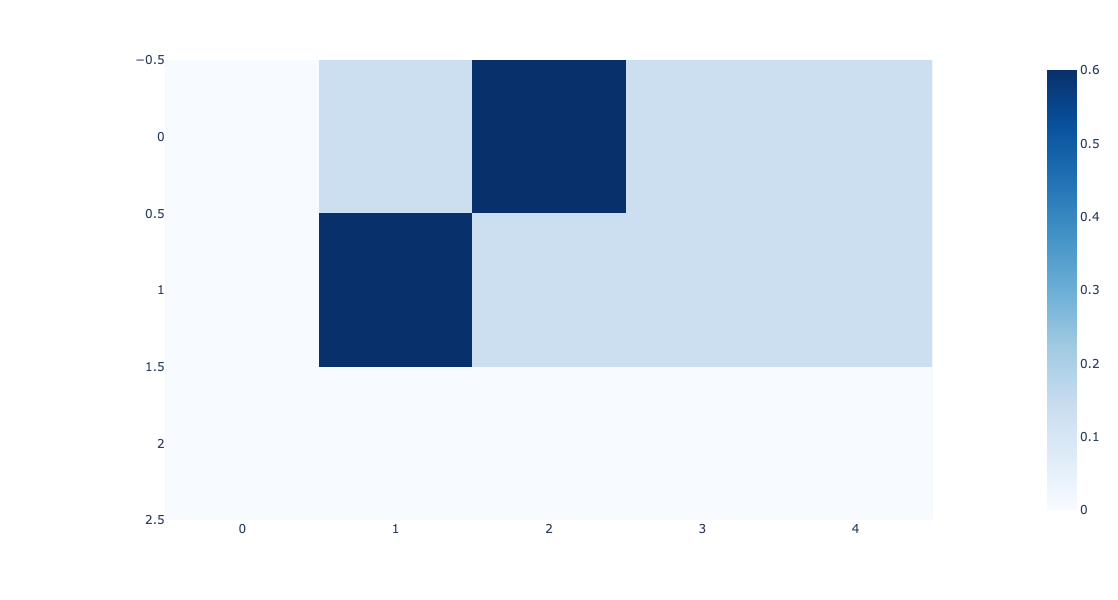

In [37]:
# Example of label smoothing.
smooth_loss = LabelSmoothingLoss(5, 0, 0.4)
predict = torch.FloatTensor([[1e-10, 0.2, 0.7, 0.1, 1e-10],
                             [1e-10, 0.2, 0.7, 0.1, 1e-10], 
                             [1e-10, 0.2, 0.7, 0.1, 1e-10]])
loss = smooth_loss(predict.log(), torch.LongTensor([2, 1, 0]))

print("smoothed target:\n",smooth_loss.true_dist,"\n") 
print("loss:",loss)
px.imshow(smooth_loss.true_dist,color_continuous_scale="blues",height=600,width=1000)


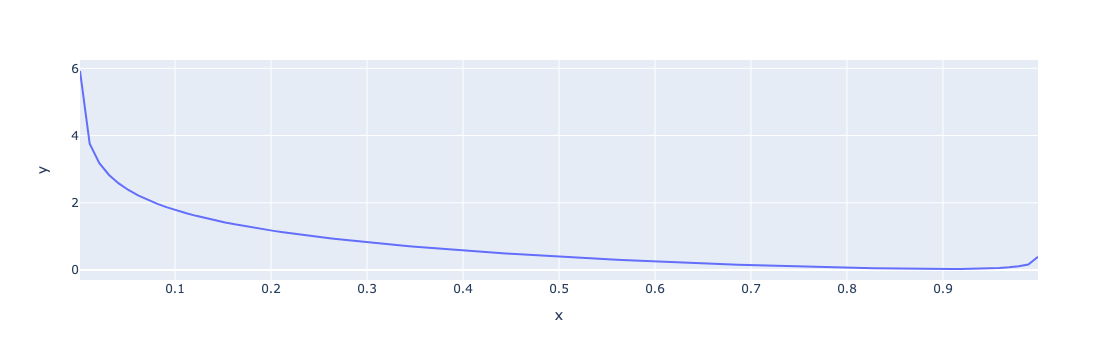

In [38]:
smooth_loss = LabelSmoothingLoss(5, 0, 0.1)
def loss(x):
    predict = torch.FloatTensor([[(1-x)/4.0, x, (1-x)/4.0, (1-x)/4.0,
                                  (1-x)/4.0]])
    return smooth_loss(predict.log(),torch.LongTensor([1]))

x = np.linspace(0.001,0.999,100)
y = [loss(i).item() for i in x]
px.line(x=x,y=y)

### 3.3 完整训练代码 

有了优化器和Loss后，我们便可以训练模型了。

我们先整体试算loss和metric，然后再套上torchkeras的训练模版。

In [39]:
#整体流程试算

for src,tgt in dl_train:
    break 
mbatch = MaskedBatch(src=src,tgt=tgt,pad = 0)

net = Transformer.from_config(src_vocab = len(vocab_x),tgt_vocab = len(vocab_y),
                   N=3, d_model=64, d_ff=128, h=8, dropout=0.1)

#loss
loss_fn = LabelSmoothingLoss(size=len(vocab_y), 
            padding_idx=0, smoothing=0.2)
preds = net.forward(mbatch.src, mbatch.tgt, mbatch.src_mask, mbatch.tgt_mask)
preds = preds.reshape(-1, preds.size(-1))
labels = mbatch.tgt_y.reshape(-1)
loss = loss_fn(preds, labels)/mbatch.ntokens 
print('loss=',loss.item())                             

#metric
preds = preds.argmax(dim=-1).view(-1)[labels!=0]
labels = labels[labels!=0]

acc = (preds==labels).sum()/(labels==labels).sum()
print('acc=',acc.item())



loss= 2.5294039249420166
acc= 0.09000000357627869


In [40]:
from torchmetrics import Accuracy 
#使用torchmetrics中的指标
accuracy = Accuracy(task='multiclass',num_classes=len(vocab_y))
accuracy.update(preds,labels)
print('acc=',accuracy.compute().item())


acc= 0.09000000357627869


下面使用我们的梦中情炉来实现最优雅的训练循环~ 

In [41]:
from torchkeras import KerasModel 

class StepRunner:
    def __init__(self, net, loss_fn, 
                 accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        src,tgt = batch 
        mbatch = MaskedBatch(src=src,tgt=tgt,pad = 0)
        
        #loss
        with self.accelerator.autocast():
            preds = net.forward(mbatch.src, mbatch.tgt, mbatch.src_mask, mbatch.tgt_mask)
            preds = preds.reshape(-1, preds.size(-1))
            labels = mbatch.tgt_y.reshape(-1)
            loss = loss_fn(preds, labels)/mbatch.ntokens 
            
            #filter padding
            preds = preds.argmax(dim=-1).view(-1)[labels!=0]
            labels = labels[labels!=0]


        #backward()
        if self.stage=="train" and self.optimizer is not None:
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        all_preds = self.accelerator.gather(preds)
        all_labels = self.accelerator.gather(labels)
        
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}

        step_metrics = {self.stage+"_"+name:metric_fn(all_preds, all_labels).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


In [42]:
from torchmetrics import Accuracy 

net = Transformer.from_config(src_vocab = len(vocab_x),tgt_vocab = len(vocab_y),
                   N=5, d_model=64, d_ff=128, h=8, dropout=0.1)


<<<<<< 🚀 mps is used >>>>>>


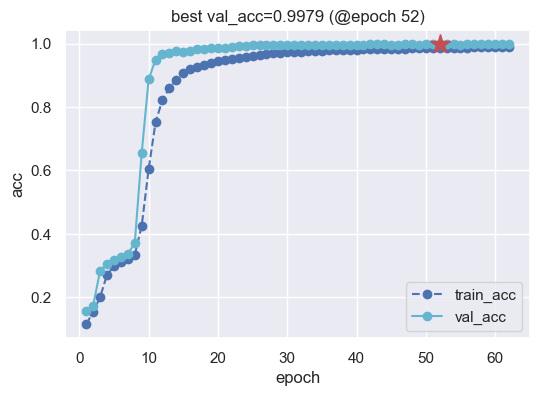

<<<<<< val_acc without improvement in 10 epoch,early stopping >>>>>> 



epoch  train_loss  train_acc        lr  val_loss   val_acc
0       1    1.926109   0.115038  0.000247  1.754101  0.157653
1       2    1.760331   0.154366  0.000494  1.714744  0.174000
2       3    1.667947   0.200666  0.000741  1.486337  0.284264
3       4    1.513071   0.271556  0.000988  1.421468  0.303679
4       5    1.438766   0.297419  0.001235  1.371336  0.317582
..    ...         ...        ...       ...       ...       ...
57     58    0.042318   0.987967  0.000734  0.013870  0.997563
58     59    0.042443   0.987949  0.000728  0.013898  0.997756
59     60    0.041574   0.988189  0.000722  0.013523  0.997648
60     61    0.041414   0.988186  0.000716  0.012791  0.997842
61     62    0.039454   0.988776  0.000710  0.012843  0.997624

[62 rows x 6 columns]

In [43]:
loss_fn = LabelSmoothingLoss(size=len(vocab_y), 
            padding_idx=0, smoothing=0.1)

metrics_dict = {'acc':Accuracy(task='multiclass',num_classes=len(vocab_y))} 
optimizer = NoamOpt(net.parameters(),model_size=64)

model = KerasModel(net,
                   loss_fn=loss_fn,
                   metrics_dict=metrics_dict,
                   optimizer = optimizer)

model.fit(
    train_data=dl_train,
    val_data=dl_val,
    epochs=100,
    ckpt_path='checkpoint',
    patience=10,
    monitor='val_acc',
    mode='max',
    callbacks=None,
    plot=True
)


## 四. 使用模型

下面使用贪心法进行翻译推理过程。

和训练过程可以通过掩码遮挡未来token，从而实现一个句子在序列长度方向并行训练不同。

翻译推理过程只有先翻译了前面的内容，添加到输出中，才能够翻译后面的内容，这个过程是无法在序列维度并行的。

Decoder&Generator第k位的输出实际上对应的是 已知 输入编码后的memory和前k位Deocder输入(解码序列)

的情况下解码序列第k+1位取 输出词典中各个词的概率。

贪心法是获取解码结果的简化方案，工程实践当中一般使用束搜索方法(Beam Search)

参考：《十分钟读懂Beam Search》 https://zhuanlan.zhihu.com/p/114669778 


In [55]:
def greedy_decode(net, src, src_mask, max_len, start_symbol):
    net.eval() 
    memory = net.encode(src, src_mask)
    ys = torch.full((len(src),max_len),start_symbol,dtype = src.dtype).to(src.device)
    for i in range(max_len-1):
        out = net.generator(net.decode(memory, src_mask, 
              ys, tril_mask(ys)))
        ys[:,i+1]=out.argmax(dim=-1)[:,i]
    return ys

def get_raw_words(tensor,vocab_r) ->"str":
    words = [vocab_r[i] for i in tensor.tolist()]
    return words

def get_words(tensor,vocab_r) ->"str":
    s = "".join([vocab_r[i] for i in tensor.tolist()])
    words = s[:s.find('<EOS>')].replace('<SOS>','')
    return words

def prepare(x,accelerator=model.accelerator):
    return x.to(accelerator.device)

In [56]:
##解码翻译结果
net = model.net
net.eval() 
net = prepare(net)
src,tgt = get_data()
src,tgt = prepare(src),prepare(tgt)
mbatch = MaskedBatch(src=src.unsqueeze(dim=0),tgt=tgt.unsqueeze(dim=0))

y_pred = greedy_decode(net,mbatch.src,mbatch.src_mask,50,vocab_y["<SOS>"])
print("input:")
print(get_words(mbatch.src[0],vocab_xr),'\n') #标签结果
print("ground truth:")
print(get_words(mbatch.tgt[0],vocab_yr),'\n') #标签结果
print("prediction:")
print(get_words(y_pred[0],vocab_yr)) #解码预测结果，原始标签中<PAD>位置的预测可以忽略


input:
69021664740654336918+64692800619 

ground truth:
69021664805347137537 

prediction:
69021664805347137537


## 五. 评估模型

我们训练过程中监控的acc实际上是字符级别的acc，现在我们来计算样本级别的准确率。

In [46]:
from tqdm.auto import tqdm

net = prepare(net)
loop = tqdm(range(1,201))
correct = 0
for i in loop:
    src,tgt = get_data()
    src,tgt = prepare(src),prepare(tgt)
    mbatch = MaskedBatch(src=src.unsqueeze(dim=0),tgt=tgt.unsqueeze(dim=0))
    y_pred = greedy_decode(net,mbatch.src,mbatch.src_mask,50,vocab_y["<SOS>"])

    inputs = get_words(mbatch.src[0],vocab_xr) #标签结果
    gt = get_words(mbatch.tgt[0],vocab_yr) #标签结果
    preds = get_words(y_pred[0],vocab_yr) #解码预测结果，原始标签中<PAD>位置的预测可以忽略
    if preds==gt:
        correct+=1
    loop.set_postfix(acc = correct/i)
    
print("acc=",correct/len(loop))
    

100%|███████████████████████████████| 200/200 [01:27<00:00,  2.28it/s, acc=0.97]

acc= 0.97


最后我们来可视化一下attention矩阵长啥样。

In [47]:
##先跑一个数据例子
net = model.net
net.eval() 
net = prepare(net)
src,tgt = get_data()
src,tgt = prepare(src),prepare(tgt)
mbatch = MaskedBatch(src=src.unsqueeze(dim=0),tgt=tgt.unsqueeze(dim=0))

In [48]:
y_pred = greedy_decode(net,mbatch.src,mbatch.src_mask,50,vocab_y["<SOS>"])
print("inputs:")
inputs = get_raw_words(mbatch.src[0],vocab_xr) #标签结果
print(inputs,'\n')

print("ground truth:")
gt = get_raw_words(mbatch.tgt[0],vocab_yr) #标签结果
print(gt,'\n')

print("prediction:")
pred = get_raw_words(y_pred[0],vocab_yr) #解码预测结果，原始标签中<PAD>位置的预测可以忽略
print(pred,'\n')

inputs:
['<SOS>', '8', '0', '9', '3', '6', '9', '1', '4', '1', '9', '5', '0', '7', '9', '+', '6', '3', '5', '3', '6', '6', '6', '8', '6', '8', '0', '0', '4', '4', '9', '2', '3', '4', '0', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 

ground truth:
['<SOS>', '6', '3', '5', '3', '7', '4', '7', '8', '0', '4', '9', '1', '8', '6', '8', '7', '4', '1', '9', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 

prediction:
['<SOS>', '6', '3', '5', '3', '7', '4', '7', '8', '0', '4', '9', '1', '8', '6', '8', '7', '4', '1', '9', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '6', '<EOS>', 

In [49]:
#encoder第0层，第0个样本，第0个head的attention矩阵
self_attn_inputs = net.encoder.layers[0].self_attn.attn[0,0,...].tolist() 
df_self_attn_inputs = pd.DataFrame(self_attn_inputs,index=inputs,
                                   columns = inputs)
selected = [i for i in range(len(inputs)) if '<PAD>' not in inputs[i]]
dfxx = df_self_attn_inputs.iloc[selected,selected]


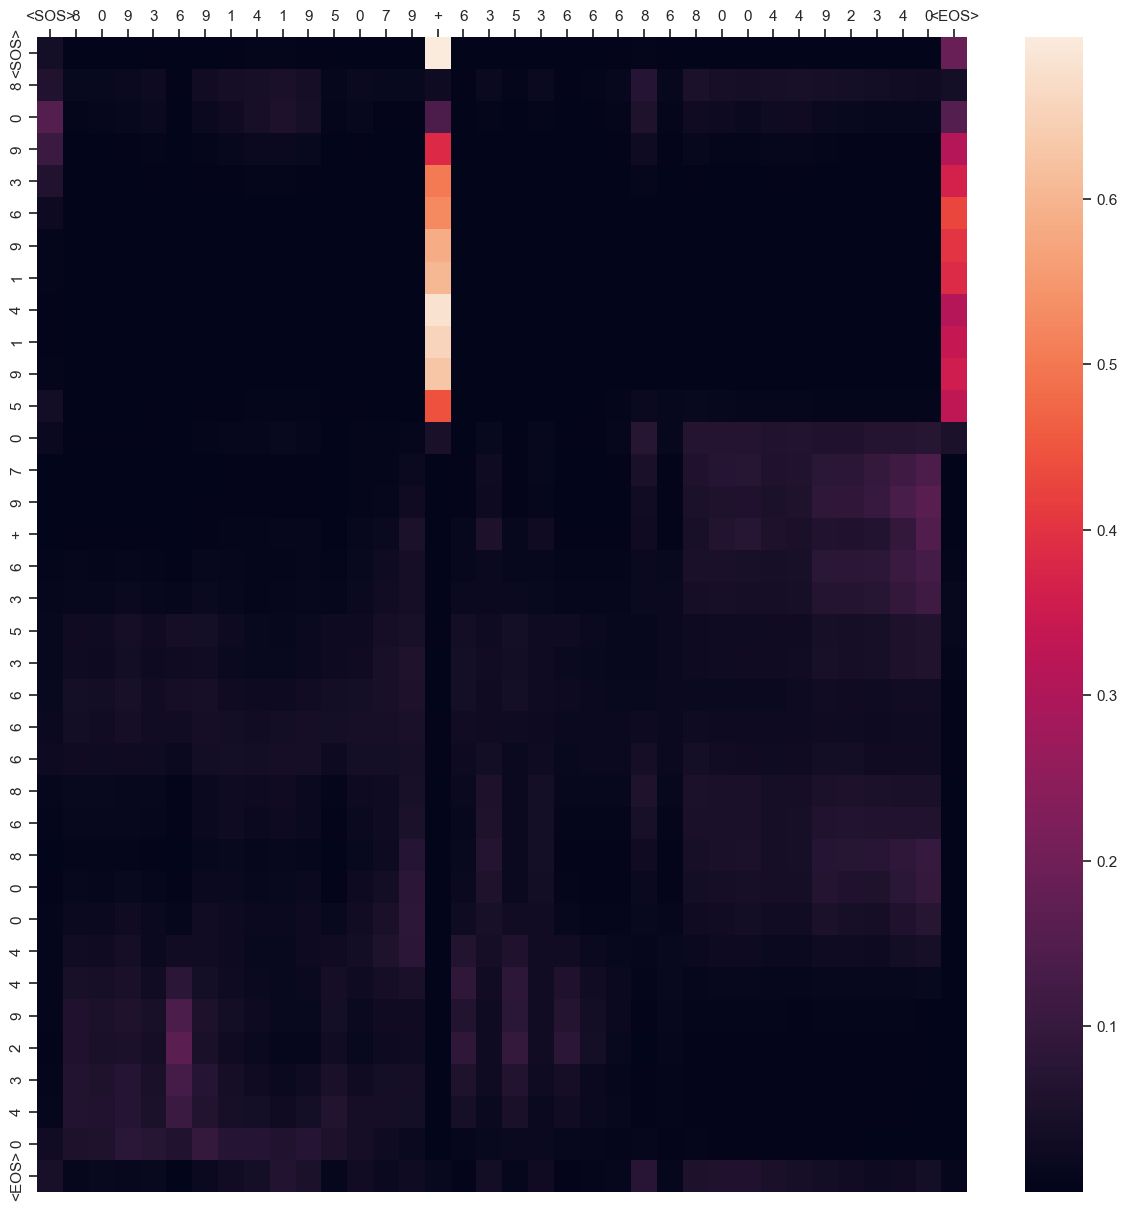

In [50]:
import seaborn as sns 
ax = sns.heatmap(dfxx)
#ax.spines['bottom'].set_position(("data", -1))
ax.yaxis.tick_left() 
ax.xaxis.tick_top() 

In [51]:
#decoder第0层，第0个样本，第0个head的cross_attention矩阵
cross_attn = net.decoder.layers[0].cross_attn.attn[0,0,...].tolist()
df_cross_attn = pd.DataFrame(cross_attn ,index=inputs,
                                   columns = pred)


In [52]:
np.array(cross_attn).shape  

(50, 50)

In [53]:
x_selected = [i for i in range(len(inputs)) if '<PAD>' not in inputs[i]]
y_selected = [i for i in range(len(inputs)) if '<PAD>' not in inputs[i]]
dfxy = df_cross_attn.iloc[x_selected,y_selected]

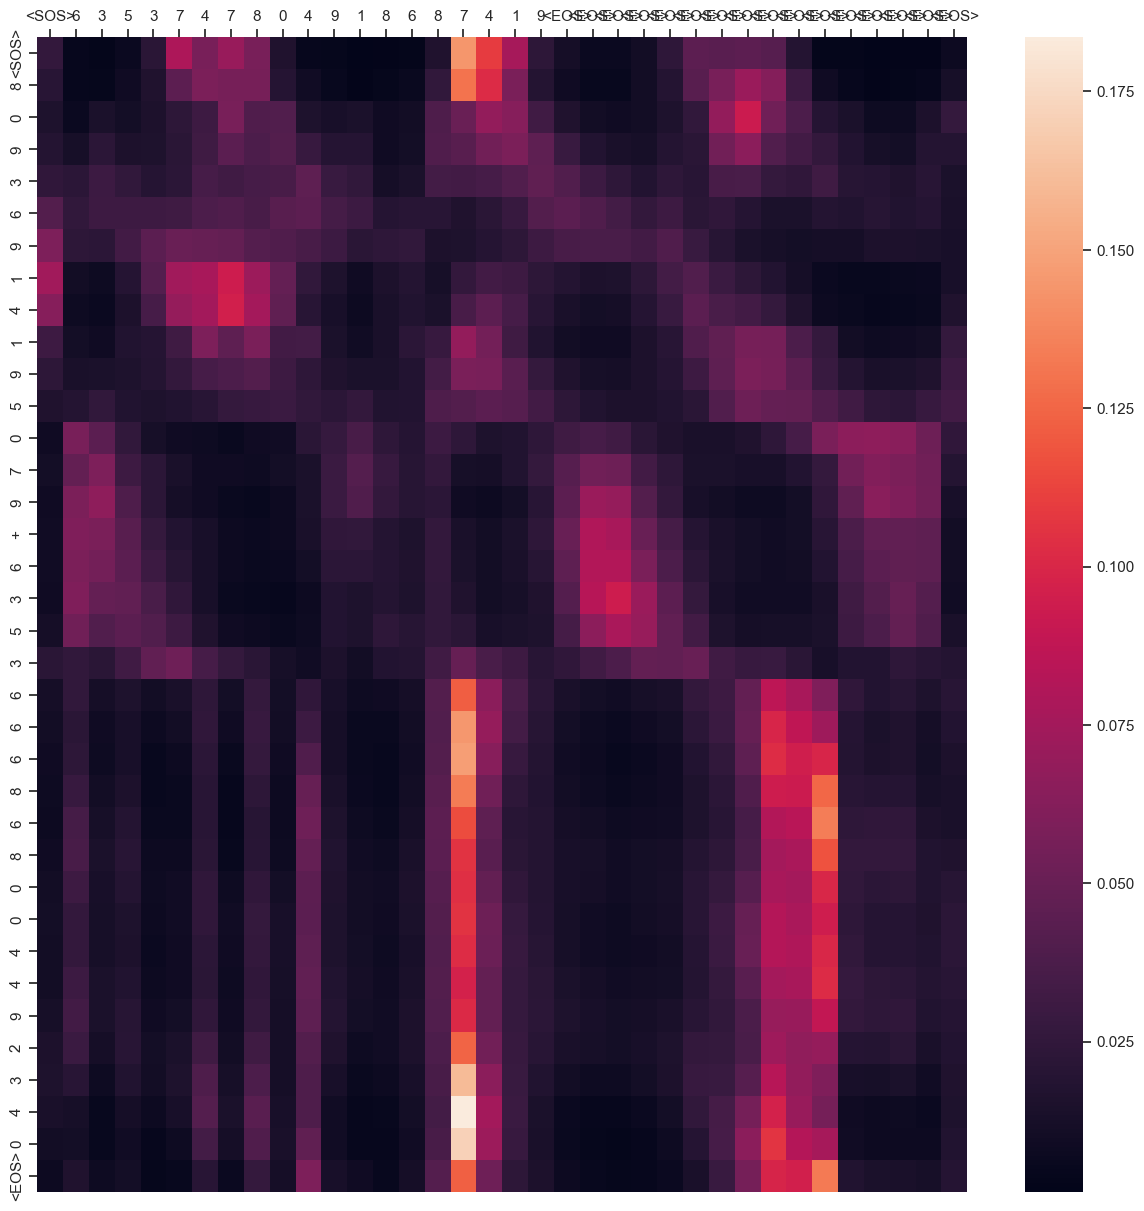

In [54]:
import seaborn as sns 
ax = sns.heatmap(dfxy)
#ax.spines['bottom'].set_position(("data", -1))
ax.yaxis.tick_left() 
ax.xaxis.tick_top() 

参考资料：

论文《Attention is All you needed》: https://arxiv.org/pdf/1706.03762.pdf

哈佛博客：https://github.com/harvardnlp/annotated-transformer/


《让研究人员绞尽脑汁的Transformer位置编码》: https://kexue.fm/archives/8130 

https://www.zhihu.com/question/338066667

《十分钟读懂Beam Search》 https://zhuanlan.zhihu.com/p/114669778